In [75]:
import numpy as np
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
import scipy.spatial as ss
import scipy.cluster as sc
import sklearn.manifold as sm
import matplotlib.pyplot as plt

In [5]:
data = np.array([
    [0.6, 1.9], [1.8, 1.6], [2.7, 2.0], [3.0, 2.1],
    [3.0, 2.6], [3.1, 4.5], [3.8, 0.6], [4.2, 2.7]
    ])
point_names = list('abcdefgh')

distance_metric = pairwise_distances(data, metric='cosine')

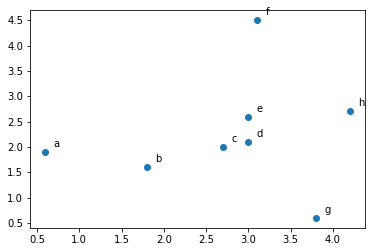

In [95]:
fig, ax = plt.subplots()

ax.scatter(x=data[:,0], y=data[:,1])

for i in range(data.shape[0]):
    ax.annotate(point_names[i], (data[i,0]+0.1, data[i,1]+0.1))

In [54]:
from tabulate import tabulate
a = np.vectorize(lambda x: f"{x:.4f}")(1 - distance_metric)
a = np.vstack([np.array(point_names), a]).T
print(tabulate(a, ['']+point_names, tablefmt="github"))

|    |      a |      b |      c |      d |      e |      f |      g |      h |
|----|--------|--------|--------|--------|--------|--------|--------|--------|
| a  | 1      | 0.8586 | 0.8096 | 0.7935 | 0.8521 | 0.9561 | 0.4462 | 0.769  |
| b  | 0.8586 | 1      | 0.996  | 0.9933 | 0.9999 | 0.9711 | 0.8419 | 0.988  |
| c  | 0.8096 | 0.996  | 1      | 0.9996 | 0.9971 | 0.946  | 0.8866 | 0.9978 |
| d  | 0.7935 | 0.9933 | 0.9996 | 1      | 0.9947 | 0.937  | 0.8986 | 0.9992 |
| e  | 0.8521 | 0.9999 | 0.9971 | 0.9947 | 1      | 0.968  | 0.8486 | 0.9898 |
| f  | 0.9561 | 0.9711 | 0.946  | 0.937  | 0.968  | 1      | 0.6888 | 0.9225 |
| g  | 0.4462 | 0.8419 | 0.8866 | 0.8986 | 0.8486 | 0.6888 | 1      | 0.9152 |
| h  | 0.769  | 0.988  | 0.9978 | 0.9992 | 0.9898 | 0.9225 | 0.9152 | 1      |


Реализуем с нуля класс для агломеративной кластеризации. Данный класс был реализован в контексте другого учебного курса. Он наследуется от абстрактных классов `BaseEstimator` и `ClusterMixin`, чтобы класс можно было использовать по API sklearn-моделей. Для эффективности используются формулы Ланса-Уильямса для быстрого пересчета расстояний с новыми кластерами:

$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

где $C_i$, $C_j$ $C_k$ - кластеры; $a_i, a_j, c$ - коэффициенты, зависящие от конкретного алгоритма


In [55]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __compute_lance_willams(self, d_ik, d_jk, d_ij, a_i, a_j, b, c):
        return a_i*d_ik + a_j*d_jk + b*d_ij + c*abs(d_ik - d_jk)
    
    def __compute_single_linkage(self, d_ik, d_jk, d_ij, i_size, j_size):
        return self.__compute_lance_willams(d_ik, d_jk, d_ij, 0.5, 0.5, 0, -0.5)
    
    def __compute_complete_linkage(self, d_ik, d_jk, d_ij, i_size, j_size):
        return self.__compute_lance_willams(d_ik, d_jk, d_ij, 0.5, 0.5, 0, 0.5)
    
    def __compute_average_linkage(self, d_ik, d_jk, d_ij, i_size, j_size):
        a_i = i_size / (i_size + j_size)
        a_j = j_size / (i_size + j_size)
        return self.__compute_lance_willams(d_ik, d_jk, d_ij, a_i, a_j, 0, 0)
    
    def __init__(self, metric='euclidean', linkage='single', n_clusters=2):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        
        self.metric = metric
        self.linkage = linkage
        self.n_clusters = n_clusters
        
        if linkage == 'single':
            self.recompute_distance = self.__compute_single_linkage
        elif linkage == 'complete':
            self.recompute_distance = self.__compute_complete_linkage
        elif linkage == 'average':
            self.recompute_distance = self.__compute_average_linkage
        else:
            raise ValueError("Wrong linkage value")
    
    def _get_linkage_matrix(self, x):
        
        distance_matrix = pairwise_distances(x, metric=self.metric)
        linkage_matrix = np.zeros((self.x_len-1, 4), dtype=np.float)
        cluster_sizes = np.ones((self.x_len*2-1))
        cluster_index_dict = {i:i for i in range(self.x_len)}
        
        for iter_num in tqdm(range(self.x_len-1), disable=True):
            
            # find minimum distance
            min_value = np.inf
            for i in range(self.x_len):
                for j in range(i+1, self.x_len):
                    if distance_matrix[i][j] < min_value:
                        min_value = distance_matrix[i][j]
                        i_min = i
                        j_min = j
            # make clustering
            cluster_sizes[i_min] = cluster_sizes[i_min] + cluster_sizes[j_min]
            linkage_matrix[iter_num] = cluster_index_dict[i_min], cluster_index_dict[j_min],\
                distance_matrix[i_min][j_min],\
                cluster_sizes[i_min]
            cluster_index_dict[i_min] = iter_num + self.x_len
            # remove j-cluster and update i-cluster
            for k in range(self.x_len):
                d_ik = distance_matrix[i_min][k]
                d_jk = distance_matrix[j_min][k]
                d_ij = min_value
                distance_matrix[i_min][k] = self.recompute_distance(d_ik, d_jk, d_ij, cluster_sizes[i_min], cluster_sizes[j_min])
                distance_matrix[k][i_min] = self.recompute_distance(d_ik, d_jk, d_ij, cluster_sizes[i_min], cluster_sizes[j_min])
            for j in range(self.x_len):
                distance_matrix[j_min][j] = np.inf
                distance_matrix[j][j_min] = np.inf
        return linkage_matrix
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.x_len = x.shape[0]
        
        self.linkage_matrix = self._get_linkage_matrix(x)
        
        self.labels_ = sc.hierarchy.cut_tree(self.linkage_matrix, n_clusters=self.n_clusters).flatten()
        return self.labels_
    
    def plot_dendrogram(self, **kwargs):
        """
        Try to visualize our data
        """
        sc.hierarchy.dendrogram(self.linkage_matrix, **kwargs)

## Single Link

100%|██████████| 7/7 [00:00<00:00, 6987.18it/s]


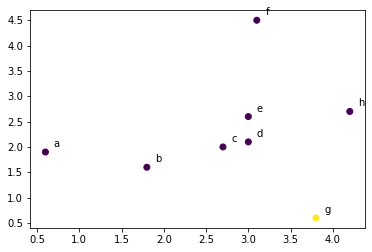

In [89]:
clustering = Clustering(metric='cosine', linkage='single')
labels = clustering.fit_predict(data)

fig, ax = plt.subplots()

ax.scatter(x=data[:,0], y=data[:,1], c=labels)

for i in range(data.shape[0]):
    ax.annotate(point_names[i], (data[i,0]+0.1, data[i,1]+0.1))

Дендрограмма кластеров:

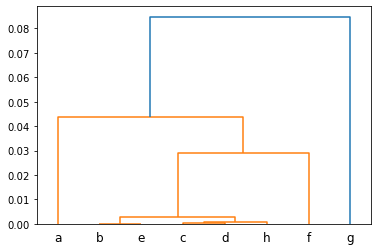

In [91]:
clustering.plot_dendrogram(labels=point_names)

## Complete Link

100%|██████████| 7/7 [00:00<00:00, 7007.19it/s]


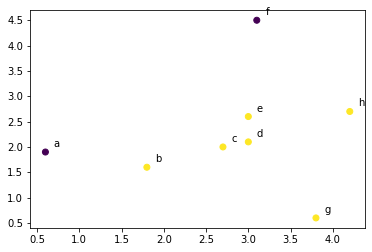

In [93]:
clustering = Clustering(metric='cosine', linkage='complete')
labels = clustering.fit_predict(data)

fig, ax = plt.subplots()

ax.scatter(x=data[:,0], y=data[:,1], c=labels)

for i in range(data.shape[0]):
    ax.annotate(point_names[i], (data[i,0]+0.1, data[i,1]+0.1))

Дендрограмма кластеров:

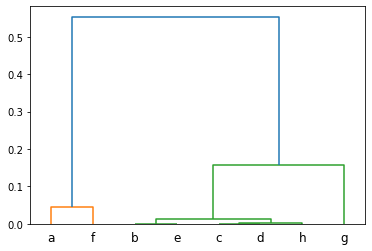

In [94]:
clustering.plot_dendrogram(labels=point_names)

## K-means

In [110]:
cluster_centroids = np.array([data[5], data[6]])
cluster_centroids

array([[3.10, 4.50],
       [3.80, 0.60]])

Шаг 1. Найдем для каждой точки ближайшку центроиду

In [111]:
current_labels = pairwise_distances(data, cluster_centroids, metric='cosine').argmin(axis=1)
current_labels

array([0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

Шаг 2. Пересчитываем центроиды кластеров

In [114]:
for c_num in range(cluster_centroids.shape[0]):
    new_cluster_centroid = data[current_labels == c_num].mean(axis=0)
    cluster_centroids[c_num] = new_cluster_centroid
cluster_centroids

array([[2.63, 2.49],
       [3.80, 0.60]])

Повторяем шаг 1.

In [113]:
current_labels = pairwise_distances(data, cluster_centroids, metric='cosine').argmin(axis=1)
current_labels

array([0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

Как можно заметить, никакие точки не поменяли своего кластера. 
Это означает, что K-means сошелся.

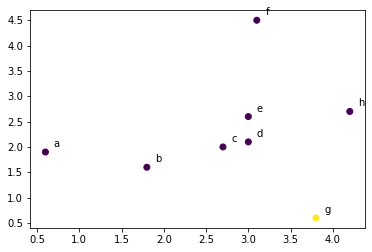

In [116]:
fig, ax = plt.subplots()

ax.scatter(x=data[:,0], y=data[:,1], c=current_labels)

for i in range(data.shape[0]):
    ax.annotate(point_names[i], (data[i,0]+0.1, data[i,1]+0.1))